# Natural Language Processing 2025-1A Homework 3

# Vector Semantics, Word2Vec and LLMs 

Deadline: 1 October (23:59)

Questions: Post them in the homework discussion on Canvas, sent them to nlp-course@utwente.nl or ask us during the practical sessions. 

How to submit: Please answer the questions directly in this notebook and submit it before the deadline.

## Please Write your group number, your names with student IDs Here: 

##### Group: group 30
##### Member names :
- Marko Haralović, student id: 3758869
- Sounic Akkaraju, student id: 3702111

Make sure that the following libraries are up-to-date in your computation envrionment. It is highly recommended to work on this assignment in UT's [JupyterLab](https://www.utwente.nl/en/service-portal/research-support/it-facilities-for-research/jupyterlab). 

In [1]:
!python -m pip install --upgrade pip
!pip3 install gensim nltk scikit-learn numpy pandas scipy 
!pip install  --upgrade gensim nltk scikit-learn numpy pandas scipy spacy ### Upgrade your libraries if neccesary

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)


We'll need these libraries later.

In [2]:
import scipy, math
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('punkt_tab')
from sklearn.metrics.pairwise import cosine_similarity 
from gensim.test.utils import datapath
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import codecs
import time
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
import sys
print(sys.executable)


/usr/bin/python


In this assignment, you will first explore two types of word vectors: those generated using co-occurrence–based methods and those produced by the local-context predictive model Word2Vec. You will then apply and evaluate an NLP task powered by a Large Language Model (LLM). 

Note on Terminology: 
- The terms "word" and "term" are used interchangeably in this context, referring to unique tokens that you aim to represent as vectors. These tokens can be individual words, n-grams, phrases, or even identifiers, but for this assignment, we will focus on individual words.
- Though "word vectors" and "word embeddings" are often used synonymously, they have distinct meanings.  According to [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding), conceptually, word embedding "*involves the mathematical embedding from space with many dimensions per word to a continuous vector space with a much lower dimension*".

# Part I. Co-occurrence count-based vectors

Let's start with this corpus consisting of 10 sentences.

In [4]:
sents=[
    "The warm sun melts the icy snow on the mountain.",
    "A warm cup of tea felt perfect in the cool morning air.",
    "Her warm smile brightened the cold winter day.",
    "I love the contrast of a warm blanket on a cold night.",
    "The cold wind chilled me, but the warm fire offered comfort.",
    "After a cold swim, the warm towel felt like heaven.",
    "The warm colors of the sunset clashed with the cold breeze.",
    "The chilly floor left her longing for the cozy comfort of slippers.",
    "A gentle breeze eased the bite of the cold ocean waves.",
    "Cold hands found solace in the warm pockets of his coat."
]


nltk.download("wordnet")
nltk.download("omw-1.4")### Exercise 1.1.1 Construct the vocabulary (0.5 point)
Before we construct co-occurrence matrices, we need to identify unique terms in the corpus, i.e. construct the vocabulary. You can remove stop words and apply other text normalisation operations before constructing the vocabulary. 

Tip: Sort your vocabulary alphabetically!

In [5]:
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# Collect unique terms in the corpus
from typing import List, Optional
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import spacy
import re

# your code starts here
def construct_vocabulary(sentences : List, text_normalization :str = "lemmatization", ignore_stopwords = True, lowercase = True):
    vocabulary = set()
    
    regex = r'[a-zA-Z]+(?:\.[a-zA-Z]+)*|\d+|[.!?,:;()"\'](?=\s)'
    
    stop_words = set(stopwords.words("english")) if ignore_stopwords else set()
    
    if text_normalization == "lemmatization":
        normalization_fn = WordNetLemmatizer().lemmatize
    elif text_normalization == "stemming":
        normalization_fn = SnowballStemmer("english", ignore_stopwords = ignore_stopwords).stem 
    else: 
        normalization_fn = None
        
    for sentence in sentences:
        if lowercase:
            sentence = sentence.lower()
        words = re.findall(regex, sentence)
        if text_normalization == "lemmatization":
            norm_words = [normalization_fn(w) for w in words if w.isalpha()]
        elif text_normalization == "stemming":
            norm_words = [normalization_fn(w) for w in words if w.isalpha()]
        else:
            norm_words = [w for w in words if w.isalpha()]
        
        if ignore_stopwords:
            norm_words = [w for w in norm_words if w not in stop_words]
        
        vocabulary.update(norm_words)
    return list(sorted(vocabulary))

# your code ends here
vocab = construct_vocabulary(sents, text_normalization = "lematization", ignore_stopwords = True, lowercase=True)
print('The size of the vocabulary is', len(vocab))
print('The words in the vocabulary are', vocab)

The size of the vocabulary is 51
The words in the vocabulary are ['air', 'bite', 'blanket', 'breeze', 'brightened', 'chilled', 'chilly', 'clashed', 'coat', 'cold', 'colors', 'comfort', 'contrast', 'cool', 'cozy', 'cup', 'day', 'eased', 'felt', 'fire', 'floor', 'found', 'gentle', 'hands', 'heaven', 'icy', 'left', 'like', 'longing', 'love', 'melts', 'morning', 'mountain', 'night', 'ocean', 'offered', 'perfect', 'pockets', 'slippers', 'smile', 'snow', 'solace', 'sun', 'sunset', 'swim', 'tea', 'towel', 'warm', 'waves', 'wind', 'winter']


### Co-Occurrence

A co-occurrence matrix counts how often terms co-occur in certain context. The context can be a complete document, a sentence, or a sliding window. 

Tip: Check out the [sklearn.feature_extraction.text](https://scikit-learn.org/stable/api/sklearn.feature_extraction.html#module-sklearn.feature_extraction.text) submodule that gathers utilities to build feature vectors from text documents. 

### Exercise 1.1.2 Term-document occurrence matrix and term-term co-occurrence matrix (0.5 point)
Let's first consider **each sentence** in the above corpus to be the context where the (co-)occurrences are counted. For example, the words *warm*, *sun*, *icy* and *snow* occur in the first sentence, therefore, they occur in this document and co-occur with each other. Going through all the sentences, you can construct the term-document occurrence matrix and term-term co-occurrence matrix. tdMatrixtdMatrixtdMatrixvocab

In [7]:
# Construct the term-document occurrence matrix

# your code starts here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=vocab)
tdMatrix = vectorizer.fit_transform(sents)
# your code ends here

print('The shape of the term-document matrix is', tdMatrix.shape)
tdMatrix_pd = pd.DataFrame.sparse.from_spmatrix(tdMatrix.T, index=vocab, columns=list(range(1, len(sents)+1)))
print('The shape of thetdMatrix_pd matrix is', tdMatrix_pd.shape)
tdMatrix_pd

The shape of the term-document matrix is (10, 51)
The shape of thetdMatrix_pd matrix is (51, 10)


,1,2,3,4,5,6,7,8,9,10
air,0,1,0,0,0,0,0,0,0,0
bite,0,0,0,0,0,0,0,0,1,0
blanket,0,0,0,1,0,0,0,0,0,0
breeze,0,0,0,0,0,0,1,0,1,0
brightened,0,0,1,0,0,0,0,0,0,0
chilled,0,0,0,0,1,0,0,0,0,0
chilly,0,0,0,0,0,0,0,1,0,0
clashed,0,0,0,0,0,0,1,0,0,0
coat,0,0,0,0,0,0,0,0,0,1
cold,0,0,1,1,1,1,1,0,1,1


The term–term co-occurrence matrix can be computed directly from the term–document occurrence matrix. When doing so, pay close attention to the diagonal entries — they indicate self-co-occurrences, which may need to be removed or adjusted depending on your application. 

In [8]:
# Construct the term-term co-occurrence matrix
# Be sure to handle the diagonal elements appropriately

# your code starts here

ttMatrix = tdMatrix.T @ tdMatrix
ttMatrix.setdiag(0)

# your code ends here
print('The shape of the term-term matrix is', ttMatrix.shape)
ttMatrix_pd = pd.DataFrame.sparse.from_spmatrix(ttMatrix, index=vocab, columns=vocab)
ttMatrix_pd

The shape of the term-term matrix is (51, 51)


,air,bite,blanket,breeze,brightened,chilled,chilly,clashed,coat,cold,...,solace,sun,sunset,swim,tea,towel,warm,waves,wind,winter
air,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
bite,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
blanket,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
breeze,0,1,0,0,0,0,0,1,0,2,...,0,0,1,0,0,0,1,1,0,0
brightened,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
chilled,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
chilly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
clashed,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
coat,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
cold,0,1,1,2,1,1,0,1,1,0,...,1,0,1,1,0,1,6,1,1,1


In [9]:
row, col = (ttMatrix_pd == ttMatrix_pd.to_numpy().max()).stack().idxmax()
print(f"{row} and {col} co-occurr {ttMatrix_pd.to_numpy().max()} times in total.")

cold and warm co-occurr 6 times in total.


Based on term-term co-occurrence matrix, which pair(s) of words co-occur the most? 

**YOUR ANSWER**: 
Pair cold and warm co-occur the most out of all word pairs, with 6 co-occurrences.


## Exercise 1.2 Cosine similarity
The benefit of vector semantics is that the similarity of two words can be computed as the cosine similarity between their vectors. Let's now compare how similar two words are. 

### Exercise 1.2.1 Calculate cosine similarity between words (0.5 point)

What is the cosine similarity between "cold" and "warm" if 1) using term-document occurrence matrix 2) using term-term co-occurrence matrix?

You may write your own cosine similarity function or use [`sklearn.metrics.pairwise.cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to calculate the pair-wise cosine similarity among all the words. 

In [10]:
# Calculate the cosine similarity between "cold" and "ward" using 1) using term-document occurrence matrix, 
# and 2) term-term co-occurrence matrix

# your code starts here
def cosine_similarity_my(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    return dot / (norm1 * norm2)

tdMatrixCosSim = cosine_similarity_my(tdMatrix_pd.loc["cold"], tdMatrix_pd.loc["warm"])
ttMatrixCosSim = cosine_similarity_my(ttMatrix_pd.loc["cold"], ttMatrix_pd.loc["warm"])

print(f"Similarity of cold and word based on document-term co-oc matrix : {tdMatrixCosSim}")
print(f"Similarity of cold and word based on term-term co-oc matrix : {ttMatrixCosSim}")

# your code ends here

Similarity of cold and word based on document-term co-oc matrix : 0.8017837257372731
Similarity of cold and word based on term-term co-oc matrix : 0.3922143335085399


### Exercise 1.2.2 (0.5 point)

Now we can calculate cosine similarity between words using a co-occurrence matrix. You can choose any previously constructed matrix for the similarity calculation. Rank all the words based on their similarity to the word *cold*.

In [11]:
# Rank all the words by their similarity to word "cold"

# your code starts here
distances = []
for word in vocab:
    if word != "cold":
        sim = cosine_similarity_my(tdMatrix_pd.loc["cold"], tdMatrix_pd.loc[word])
        distances.append((sim, word))

distances = sorted(distances, key=lambda x: x[0], reverse=True)
print("Using term-document matrix:")
for sim, word in distances:
    print(word, ":", sim)

distances = []
for word in vocab:
    if word != "cold":
        sim = cosine_similarity_my(ttMatrix_pd.loc["cold"], ttMatrix_pd.loc[word])
        distances.append((sim, word))

distances = sorted(distances, key=lambda x: x[0], reverse=True)
print("\nUsing term-term matrix:")
for sim, word in distances:
    print(word, ":", sim)

# your code ends here

Using term-document matrix:
warm : 0.8017837257372731
breeze : 0.5345224838248487
bite : 0.3779644730092272
blanket : 0.3779644730092272
brightened : 0.3779644730092272
chilled : 0.3779644730092272
clashed : 0.3779644730092272
coat : 0.3779644730092272
colors : 0.3779644730092272
contrast : 0.3779644730092272
day : 0.3779644730092272
eased : 0.3779644730092272
fire : 0.3779644730092272
found : 0.3779644730092272
gentle : 0.3779644730092272
hands : 0.3779644730092272
heaven : 0.3779644730092272
like : 0.3779644730092272
love : 0.3779644730092272
night : 0.3779644730092272
ocean : 0.3779644730092272
offered : 0.3779644730092272
pockets : 0.3779644730092272
smile : 0.3779644730092272
solace : 0.3779644730092272
sunset : 0.3779644730092272
swim : 0.3779644730092272
towel : 0.3779644730092272
waves : 0.3779644730092272
wind : 0.3779644730092272
winter : 0.3779644730092272
comfort : 0.26726124191242434
felt : 0.26726124191242434
air : 0.0
chilly : 0.0
cool : 0.0
cozy : 0.0
cup : 0.0
floor : 

The calculated cosine similarity does not appear to capture semantic similarity or relatedness reliably. How might we obtain more meaningful similarity measures?

**YOUR ANSWER**: In the lecture we introduced TF-IDF, we think that would help with the results, so lower number of all too common words wouldnt be returned. We are also looking at the term-document occurences, an upgrade would be to have a sliding window approach to determine if the words appear in the same context and in the same position in the sentence.

# Exercise 1.3 TF-IDF

## Excercise 1.3.1 (0.5 point)
For the above corpus, construct a TF-IDF weighted term-document matrix, using [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [12]:
# Construct a TF-IDF weighted term-document matrix

# your code starts here
from sklearn.feature_extraction.text import TfidfVectorizer          
vectorizer = TfidfVectorizer()
tfIdfMatrix = vectorizer.fit_transform(sents)
print('The shape of the TF-IDF matrix is', tfIdfMatrix.shape)
tfIdfMatrix_pd = pd.DataFrame.sparse.from_spmatrix(tfIdfMatrix.T, index=vectorizer.get_feature_names_out(), columns=list(range(len(sents))))
tfIdfMatrix_pd
# your code ends here

The shape of the TF-IDF matrix is (10, 62)


,0,1,2,3,4,5,6,7,8,9
after,0,0,0,0,0,0.398599,0,0,0,0
air,0,0.352077,0,0,0,0,0,0,0,0
bite,0,0,0,0,0,0,0,0,0.383617,0
blanket,0,0,0,0.42325,0,0,0,0,0,0
breeze,0,0,0,0,0,0,0.329015,0,0.32611,0
...,...,...,...,...,...,...,...,...,...,...
warm,0.166014,0.156291,0.192932,0.187886,0.159932,0.176943,0.171809,0,0,0.161213
waves,0,0,0,0,0,0,0,0,0.383617,0
wind,0,0,0,0,0.360279,0,0,0,0,0
winter,0,0,0.434617,0,0,0,0,0,0,0


Compute and rank the words in descending order based on their similarity to *cold*. 

In [13]:
# Compute and rank the words in descending order based on their similarity to *cold*

# Your code starts here

distances = []
for word in vocab:
    if word != "cold":
        sim = cosine_similarity_my(tfIdfMatrix_pd.loc["cold"], tfIdfMatrix_pd.loc[word])
        distances.append((sim, word))

distances = sorted(distances, key=lambda x: x[0], reverse=True)
print("Using TF-IDF matrix:")
for sim, word in distances:
    print(word, ":", sim)

# Your code ends here

Using TF-IDF matrix:
warm : 0.821426502771318
breeze : 0.5230226303522726
brightened : 0.41713832678268736
day : 0.41713832678268736
smile : 0.41713832678268736
winter : 0.41713832678268736
blanket : 0.4062281511043087
contrast : 0.4062281511043087
love : 0.4062281511043087
night : 0.4062281511043087
heaven : 0.3825681770642013
like : 0.3825681770642013
swim : 0.3825681770642013
towel : 0.3825681770642013
clashed : 0.3714692891396049
colors : 0.3714692891396049
sunset : 0.3714692891396049
bite : 0.3681891349384532
eased : 0.3681891349384532
gentle : 0.3681891349384532
ocean : 0.3681891349384532
waves : 0.3681891349384532
coat : 0.34855809088144746
found : 0.34855809088144746
hands : 0.34855809088144746
pockets : 0.34855809088144746
solace : 0.34855809088144746
chilled : 0.3457896483377711
fire : 0.3457896483377711
offered : 0.3457896483377711
wind : 0.3457896483377711
felt : 0.2867312920148833
comfort : 0.2556039270346906
air : 0.0
chilly : 0.0
cool : 0.0
cozy : 0.0
cup : 0.0
floor : 0

## Exercise 1.3.2 (0.5 point)

Let's use a bigger dataset which contains 2225 BBC news articles to construct TF-IDF term-document matrix. 

In [14]:
sents=codecs.open('bbc-text.csv','r', encoding='utf-8').readlines() # load the data

# your code starts here

vocab = construct_vocabulary(sents, text_normalization = "lemmatization", ignore_stopwords = True, lowercase=True)
vectorizer = TfidfVectorizer()
tfIdfMatrix = vectorizer.fit_transform(sents)
print('The shape of the TF-IDF matrix is', tfIdfMatrix.shape)
term_doc_matrix = pd.DataFrame.sparse.from_spmatrix(tfIdfMatrix.T, index=vectorizer.get_feature_names_out(), columns=list(range(len(sents))))

# your code ends here

print('The size of the vocabulary is', len(vocab))
print('The shape of the term-document matrix is', term_doc_matrix.shape)



The shape of the TF-IDF matrix is (2226, 29421)
The size of the vocabulary is 24713
The shape of the term-document matrix is (29421, 2226)


We can compute which words are most similar to *cold*. Does this list of words make more sense now and why?

**YOUR ANSWER**: The words are not really similar to cold. For instance, heating makes sense to be connected to cold, but it is not similar per say, it's the opposite.Some of other words are good examples, but most of them are completely not useful, like "opec", "adnan", "eldin", "cartel", "teag", "brent", etc. We were surprised by these results as we'd deem them as not that useful.


In [15]:
# Find the top 10 words that are most similar to word "cold"

# your code starts here

def find_similar_words(matrix, target_term, top_n):
    vec_target = matrix.loc[target_term].sparse.to_dense().values.reshape(1, -1)
    all_vecs = matrix.sparse.to_dense().values
    sims = cosine_similarity(vec_target, all_vecs).ravel()

    sims[matrix.index.get_loc(target_term)] = -np.inf

    top_idx = np.argsort(-sims)[:top_n]
    return top_idx, sims

top_idx, sims = find_similar_words(term_doc_matrix, "cold", 10)

print(f"Top {len(top_idx)} words similar to 'cold':")
for i in top_idx:
    print(f"{term_doc_matrix.index[i]} : {sims[i]:.6f}")

# your code ends here

Top 10 words similar to 'cold':
opec : 0.485556
heating : 0.438346
crude : 0.437255
brent : 0.404701
cartel : 0.396567
barrel : 0.389455
retreated : 0.385683
adnan : 0.385683
eldin : 0.385683
conservation : 0.384195


In [16]:
terms = vectorizer.get_feature_names_out()
M = tfIdfMatrix.T.tocoo()  # (n_terms, n_docs)
i = M.data.argmax()
term = terms[M.row[i]]
doc_id = M.col[i]
val = M.data[i]
print(f"Max TF-IDF: term '{term}' in document {doc_id} with weight {val:.3f}")


Max TF-IDF: term 'commodore' in document 1204 with weight 0.747


Find another 3 pairs of words whose cosine similarity makes sense to you.

In [17]:
# Look for 3 pairs of words whose cosine similarities reflect their semantic similarity or relatedness.

def pair_similarity(vectorizer, tfidf, w1, w2):
    terms = vectorizer.get_feature_names_out()
    m = {t:i for i,t in enumerate(terms)}
    if w1 not in m or w2 not in m:
        return None
    return float(cosine_similarity(tfidf[m[w1]], tfidf[m[w2]])[0,0])

pairs = [
    ("oil","crude"),
    ("shares","stocks"),
    ("government","minister"),
    ("football","match"),
    ("winter","snow"),
    ("economy","growth"),
    ("court","judge"),
    ("ball", "sport"),
    ("economy","state"),
    ("court","lawyer"),
    ("car","driver"),
    ("light","electricity"),
    ("rain","weather"),
    ("doctor","hospital"),
    ("market","trade")
]

scored = [(p, pair_similarity(vectorizer, tfIdfMatrix.T, *p)) for p in pairs]
scored = [(p,s) for p,s in scored if s is not None]
scored.sort(key=lambda x: x[1], reverse=True)

for (w1,w2), s in scored[:3]:
    print(f"{w1} – {w2}: {s:.6f}")



economy – growth: 0.676652
oil – crude: 0.505441
government – minister: 0.400466


# Part II. Word2Vec word vectors

Here, we explore the embeddings produced by word2vec. Please read J&M 6.8 or the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) if you are interested in the details of the algorithm.

## Exercise 2.1 Pre-train word2vec model

Run the following script to load the word2vec vectors into memory. **Note**: This might take several minutes. If you run out of memory, try closing other applicaions or restart your machine to free more memory. 

Please note, the following experiments run with Gensim 4.3.3. If you are still running an old version of Gensim, please upgrade your Gensim library or check [Migrating from Gensim 3.x to 4](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4) to adapt your code. 

In [18]:
# Load 3 million Word2Vec Vectors, pre-trained on Google news, each with the dimension of 300
# This model may take a few minutes to load.

import gensim.downloader as api
start_time = time.time()
w2v_google = api.load("word2vec-google-news-300")
print("--- %s seconds ---" % (time.time() - start_time))

--- 32.64700198173523 seconds ---


In [19]:
print("Loaded vocab size {}".format(len(w2v_google.index_to_key)))

Loaded vocab size 3000000


Once the model is loaded, you can extract the vector for individual words directly using `wv_google['']`

In [20]:
w2v_google['cold']

array([-1.89208984e-02,  1.18652344e-01, -6.25000000e-02,  7.86132812e-02,
       -3.46679688e-02,  2.51953125e-01,  2.06298828e-02, -1.64062500e-01,
       -2.12402344e-02,  3.18359375e-01,  6.93359375e-02, -1.56250000e-01,
       -4.80957031e-02, -4.63485718e-04,  1.45874023e-02, -7.04956055e-03,
       -1.00708008e-03, -2.00195312e-02,  1.53320312e-01, -2.53906250e-01,
        4.08935547e-03,  1.51367188e-01, -5.88378906e-02, -1.30859375e-01,
        1.79687500e-01, -5.00488281e-03,  7.61718750e-02,  1.09863281e-01,
       -2.19726562e-01, -4.15039062e-02, -6.93359375e-02,  6.98242188e-02,
        2.49023438e-01,  1.29882812e-01, -2.85156250e-01, -7.95898438e-02,
       -1.04003906e-01,  1.95312500e-02,  1.42578125e-01,  1.08886719e-01,
        2.07031250e-01, -2.94921875e-01,  1.50390625e-01, -1.65039062e-01,
       -4.05273438e-02,  3.11279297e-02, -2.59765625e-01,  3.63769531e-02,
       -1.67968750e-01,  2.14843750e-01,  7.32421875e-02,  1.65039062e-01,
       -2.35351562e-01,  

In [21]:
w2v_google['cold'].shape

(300,)

One of the property of semantic embedding is that similar words are embedded close to each other. Use  `w2v_google.most_similar()` to identify the most similar words to *north*. Does this list make more sense to you? 

In [22]:
start_time = time.time()
for w,c in w2v_google.most_similar('cold'):
    print(w,c)
print("--- %s seconds ---" % (time.time() - start_time))

chilly 0.6878557205200195
frigid 0.6770406365394592
Cold 0.6727538704872131
bitterly_cold 0.6375916600227356
chill 0.6324006915092468
warm 0.5953035950660706
colder 0.590000331401825
TONIGHT_Clear 0.5773205757141113
frosty 0.5743643045425415
frigid_weather 0.5725992918014526
--- 0.7577188014984131 seconds ---


Check a few more words to see whether their most similar words make sense to you and explain why. 

In [23]:
w2v_google.most_similar('black')

[('white', 0.8092213869094849),
 ('Responded_Letterman_How', 0.6182776689529419),
 ('blacks', 0.589222252368927),
 ('crypt_inscribed', 0.5855618119239807),
 ('transporting_petrochemicals', 0.5834174752235413),
 ('brown', 0.5766680240631104),
 ('Shilah_Phillips', 0.5763780474662781),
 ('women_dating_interracially', 0.5670552253723145),
 ('wrote_Newitz', 0.5604413747787476),
 ('blue', 0.5492398142814636)]

In [24]:
w2v_google.most_similar('table')

[('tables', 0.695063591003418),
 ('ConocoPhillips_BPAmerica', 0.4951048493385315),
 ('Capitalized_Included', 0.46665358543395996),
 ('tray', 0.4653456509113312),
 ('dining_room', 0.45831137895584106),
 ('banquette', 0.4455730617046356),
 ('rapping_cappella', 0.4435313045978546),
 ('sideboard', 0.44340983033180237),
 ('linen_tablecloth', 0.4422051012516022),
 ('Tables', 0.44195544719696045)]

In [25]:
w2v_google.most_similar('cheese')

[('cheeses', 0.7788999676704407),
 ('cheddar', 0.7627597451210022),
 ('goat_cheese', 0.7297402024269104),
 ('Cheese', 0.7286962270736694),
 ('cheddar_cheese', 0.725513756275177),
 ('Cheddar_cheese', 0.6943708658218384),
 ('mozzarella', 0.6805710792541504),
 ('cheddar_cheeses', 0.6694672107696533),
 ('Camembert', 0.6623162031173706),
 ('gruyere', 0.6615148186683655)]

## Word analogies

An analogy explains one thing in terms of another to highlight the ways in which they are alike. For example, *paris* is similar to *france* in the same way that *rome* is to *italy*. Word2Vec vectors sometimes shows the ability of solving analogy problem of the form **a is to b as a* is to what?**.

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value). In the case below, the top one word *italy* is the answer, so this analogy is solved successfully.

In [26]:
# Run this cell to answer the analogy -- paris : france :: rome : x
print(w2v_google.most_similar(positive=['rome', 'france'], negative=['paris']))

[('italy', 0.519952118396759), ('european', 0.5075845718383789), ('italian', 0.5057743191719055), ('epl', 0.490744411945343), ('spain', 0.4888668656349182), ('england', 0.4852672219276428), ('italians', 0.4842422604560852), ('kosovo', 0.48134922981262207), ('lampard', 0.4807734787464142), ('malta', 0.4788566529750824)]


### Exercise 2.1.1 (0.5 point)
Look for one analogy that can be solved successfully and one analogy that could not be solved using this pre-trained Word2Vec model. Check out [this paper](https://www.semanticscholar.org/paper/Efficient-Estimation-of-Word-Representations-in-Mikolov-Chen/330da625c15427c6e42ccfa3b747fb29e5835bf0) for inspirations.

In [ ]:
# Your successful case goes here
print(w2v_google.most_similar(positive=['good', 'bigger'], negative=['big']))

# Your failed case goes here
print(w2v_google.most_similar(positive=['devil', 'god'], negative=['paradise'])) # were expecting inferno

# this is also a possible failcase in case bias is classified as a negative
print(w2v_google.most_similar(positive=['nurse', 'man'], negative=['plumber']))


[('better', 0.7805920839309692), ('stronger', 0.607010543346405), ('nicer', 0.5803204774856567), ('worse', 0.5609191060066223), ('quicker', 0.5379599332809448), ('decent', 0.5300450921058655), ('happier', 0.5073164105415344), ('rosier', 0.5062008500099182), ('excellent', 0.5028262734413147), ('bad', 0.4903066158294678)]
[('Satan', 0.5613356828689575), ('gods', 0.5406335592269897), ('deity', 0.5344845652580261), ('Beelzebub', 0.5267392992973328), ('God', 0.5201724767684937), ('Baphomet', 0.5149897933006287), ('satan', 0.5118672847747803), ('demon', 0.5051606297492981), ('Almighty', 0.4951082468032837), ('lord', 0.4945856034755707)]
[('woman', 0.6268700361251831), ('girl', 0.5305523872375488), ('teenage_girl', 0.529351532459259), ('boy', 0.4857897162437439), ('teenager', 0.4767230153083801), ('awoman', 0.47001713514328003), ('Gunshot_victim', 0.4619367718696594), ('patient', 0.45929551124572754), ('American_Emily_Kerstetter', 0.44990482926368713), ('victim', 0.4425661861896515)]


## Visualising word analogies

The following cell shows you how to use [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to visualise a set of words based on their embeddings. You can also apply other dimensionality reduction methods (e.g. [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)) to reduce the vectors from 300-dimensional to 2 dimensional. 

Please note, reducing dimensionality from 300 to 2 is a very challenging task. You can try different parameters in the tSNE and see their effects on the final visualisation. In particular, the visualisation is very sensitive to the perplexity value that you give. Please try a few different perplexity valuse and keep the one that gives the most reasonable visusalisation. 

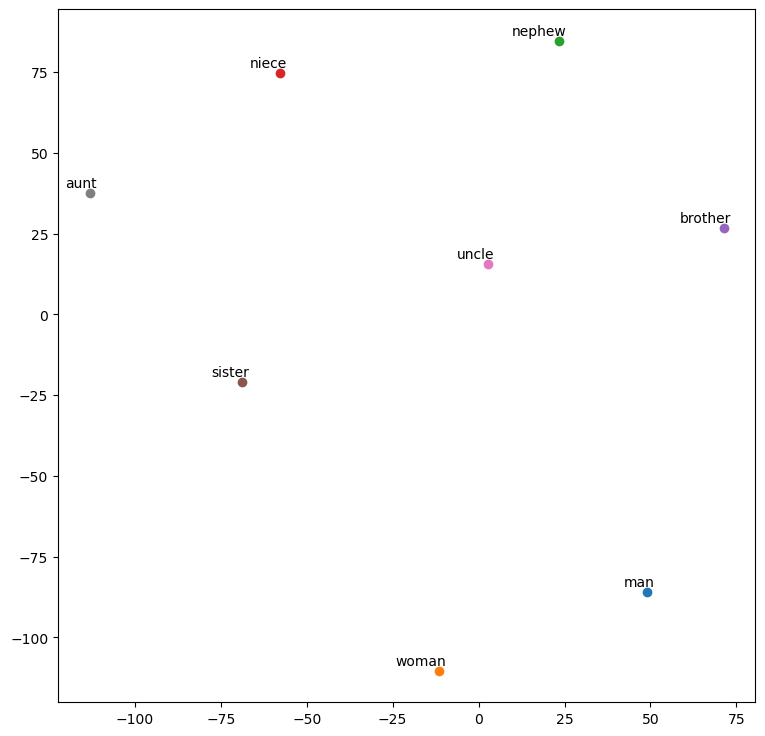

In [28]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def tsne_plot(model, wordlist, p):
    labels = []
    tokens = []
    
    for word in wordlist:
        tokens.append(model[word])
        labels.append(word)
    
    tokens = np.array(tokens)
    
    tsne_model = TSNE(perplexity=p, n_components=2, init='pca', max_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(9,9))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

wordlist = ['man', 'woman', 'nephew', 'niece', 'brother', 'sister', 'uncle', 'aunt']
tsne_plot(w2v_google, wordlist, len(wordlist)-2)


### Exercise 2.1.2 (0.5 point)
Find another group analogies (at least 3 pairs of words) and see how they are visualised.  

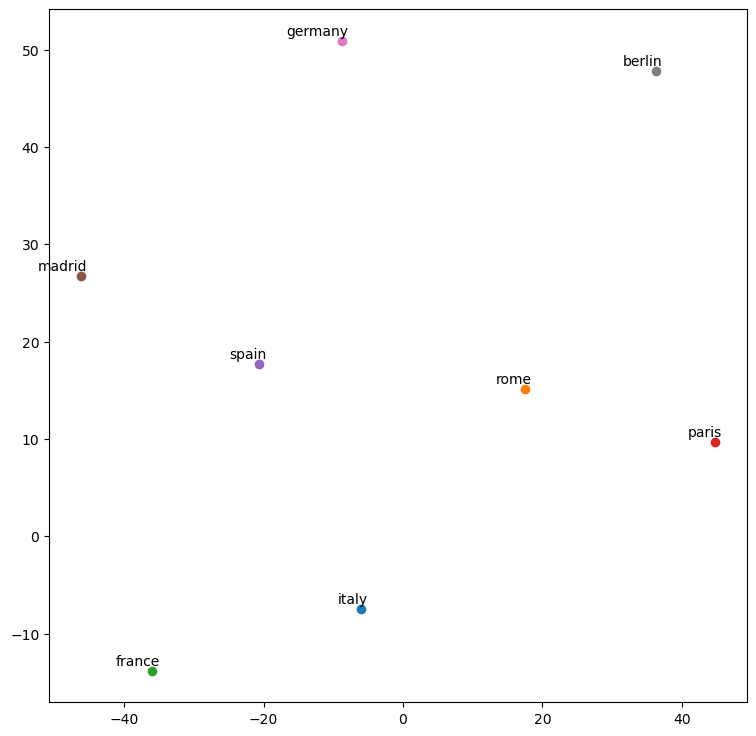

In [29]:
# prepare at least 3 pairs of words   

# your answer goes here
wordlist = ['italy','rome','france','paris','spain','madrid','germany','berlin']

p=len(wordlist)-1
tsne_plot(w2v_google,wordlist,p-2)

### Exercise 2.1.3  Synonyms and antonyms (0.5 point)



Find three words (w1, w2, w3) so that 
- w1 and w2 are synonyms, 
- w1 and w3 are antonyms, 
- cosine_distance(w1, w2) > cosine_distance(w1, w3) or cosine_distance(w1, w2) $\approx$ cosine_distance(w1, w3). 

Please give a possible explanation for why this has happened. 

You can use [`w2v_google.distance()`](https://radimrehurek.com/gensim/models/keyedvectors.html) function to compute the cosine distance between two words. 

In [30]:
# Replace XXX, YYY and ZZZ with your chosen words

w1='sweet'
w2a='sweetened'
w2b='sugary'
w3='salty'

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2a, w2v_google.distance(w1, w2a)))
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2b, w2v_google.distance(w1, w2b)))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w2v_google.distance(w1, w3)))


Synonyms sweet, sweetened have cosine distance: 0.6735030114650726
Synonyms sweet, sugary have cosine distance: 0.4888039231300354
Antonyms sweet, salty have cosine distance: 0.5050951242446899


**Your answer**:  Sweet is closer to salty than to sweetened, and similarly as close to salty as to sugary. Our explanation would be that, in this case, sweet and salty occur more frequently in the same context in sentences together (we thought of recipes, food lists, reviews, in which such words could both occur). While sweetened is a synonym, we argue that sweetened is not that often used in the same context as sweet, while salty is. The fact that salty is an antonym is overridden by the fact that it appears more frequently in the sliding window around sweet. Sugary is an example of a synonym that is often used to describe food, and is obviously present more often in the context window around sweet; therefore, the distance between sweet and sugary matches the difference between sweet and salty.
NOTE: sweet is also a polysemous word, but in this case we refer to the literate meaning of the sweet, characterizing taste of something.w1='equal'


In [31]:
w1='equal'
w2a='equivalent'
w2b='identical'
w3='unequal'

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2a, w2v_google.distance(w1, w2a)))
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2b, w2v_google.distance(w1, w2b)))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w2v_google.distance(w1, w3)))


Synonyms equal, equivalent have cosine distance: 0.5615076124668121
Synonyms equal, identical have cosine distance: 0.6113005578517914
Antonyms equal, unequal have cosine distance: 0.45773208141326904


### Exercise 2.1.4 Polysemous Words (0.5 point)

Some words are polysemous, i.e. they have multiple meanings. For example the word *bank* can be a financial institute or the rising ground bordering a lake or river. Find a polysemous word whose top most similar words contains related words from multiple meanings. You should use the the [`wv_google.most_similar()`](https://radimrehurek.com/gensim/models/keyedvectors.html) function to compute the closet neighbours of the word. You may increase the number of neighbours in order to identify multiple groups of meanings. Submit the ranked word list and explained how the words are grouped into different meanings.

In [32]:
w2v_google.most_similar('crane',topn=50)

[('cranes', 0.7692900896072388),
 ('scaffolding', 0.6770226955413818),
 ('cherry_picker', 0.6515053510665894),
 ('hydraulic_crane', 0.6279746890068054),
 ('girder', 0.623549222946167),
 ('forklift', 0.6210452914237976),
 ('gantry_crane', 0.6148872375488281),
 ('crane_toppled', 0.6126982569694519),
 ('excavator', 0.6093015670776367),
 ('tower_cranes', 0.6078611612319946),
 ('manlift', 0.6062108278274536),
 ('cherrypicker', 0.5868619084358215),
 ('winch', 0.5834875702857971),
 ('scaffold', 0.5760444402694702),
 ('overhead_cranes', 0.5720781683921814),
 ('crawler_crane', 0.5694176554679871),
 ('steel_girder', 0.5667331218719482),
 ('pallet_jack', 0.5615602731704712),
 ('crane_barge', 0.5610539317131042),
 ('trackhoe', 0.5599021315574646),
 ('crane_operator', 0.558091402053833),
 ('girders', 0.5569372177124023),
 ('hydraulic_jacks', 0.551821231842041),
 ('falsework', 0.5491117238998413),
 ('fork_lift', 0.5467649698257446),
 ('telescopic_boom', 0.5462592840194702),
 ('payloader', 0.54228931

['crane', 'cranes', 'scaffolding', 'cherry_picker', 'hydraulic_crane', 'girder', 'forklift', 'gantry_crane', 'crane_toppled', 'excavator', 'tower_cranes', 'manlift', 'cherrypicker', 'winch', 'scaffold', 'overhead_cranes', 'crawler_crane', 'steel_girder', 'pallet_jack', 'crane_barge', 'trackhoe', 'crane_operator', 'girders', 'hydraulic_jacks', 'falsework', 'fork_lift', 'telescopic_boom', 'payloader', 'barge', 'ton_girder', 'hydraulic_cranes', 'concrete_girder', 'flatbed_tractor_trailer', 'fiberglass_walleye', 'flatbed_truck', 'launching_girder', 'steel_girders', 'bosun_chair', 'hydraulic_excavator', 'backhoe', 'jib_crane', 'telehandler', 'steel_beams', 'crawler_cranes', 'truss', 'concrete_girders', 'luffing_jib', 'scaffolding_collapsed', 'scissor_lift', 'crane_rigger', 'crane_hoists', 'telescopic_crane', 'gantry', 'roof_trusses', 'gantry_cranes', '###ft_crane', 'flatbed_trailer', 'nylon_slings', 'elevator_shaft', 'pontoons', 'derrick', 'hydraulic_lift', 'steel_trusses', 'trusses', 'pont

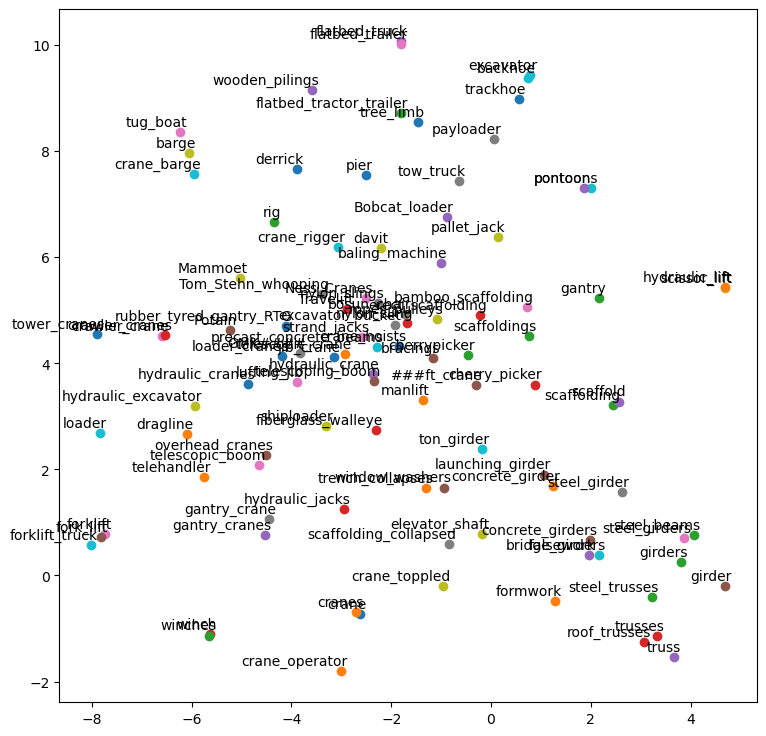

In [33]:
focusword='crane'
wordlist=[focusword]
for w in w2v_google.most_similar(focusword,topn=100):
    wordlist.append(w[0])
print(wordlist)
tsne_plot(w2v_google,wordlist,20)

In [34]:
## OR EXAMPLE
w2v_google.most_similar('nice',topn=50)

[('good', 0.6836091876029968),
 ('lovely', 0.6676310896873474),
 ('neat', 0.6616737246513367),
 ('fantastic', 0.6569240689277649),
 ('wonderful', 0.6561347246170044),
 ('terrific', 0.6552367806434631),
 ('great', 0.6454657912254333),
 ('awesome', 0.6404187679290771),
 ('nicer', 0.6302445530891418),
 ('decent', 0.5993332862854004),
 ('fabulous', 0.5919305682182312),
 ('really', 0.5768200159072876),
 ('amazing', 0.5744078755378723),
 ('pleasant', 0.568358838558197),
 ('heck', 0.5609056949615479),
 ('classy', 0.5590802431106567),
 ('happy', 0.558428168296814),
 ('liked', 0.5552058219909668),
 ('fun', 0.55433189868927),
 ('marvelous', 0.546456515789032),
 ('definitely', 0.5463722944259644),
 ('beautiful', 0.5340619087219238),
 ('Necth_described', 0.5338279008865356),
 ('weird', 0.5319892168045044),
 ('safe_Deche', 0.5291000604629517),
 ('perfect', 0.52525794506073),
 ('kinda_weird', 0.5241473913192749),
 ('Choreographed_chaos', 0.5195640921592712),
 ('alright', 0.5183937549591064),
 ('Wow'

Identified groups of words similar to nice grouped by meaning:
- adjective/a quality of a person,: good, great, wonderful, terrific, fantastic, awesome, amazing, fabulous, marvelous, perfect, lovely, classy, decent, nifty
- beauty and looks : beautiful, gorgeous, pretty
- word related to nice as being a approval of smth: neat, fantastic, definetely, perfect, interesting, okay
- degree words: really, definitely, pretty, nicely, maybe, kinda, alright, okay

Look into literature and describe potential methods to address this polysymy issue in word embeddings. Please cite the papers that you refer to. 

**YOUR ANSWER**: [1] suggest training a multiple embeddings for each of the words. Idea is to perform a forward pass through the model and extrapolate different embeddings from a singular vector representation, hypothesizing that that would lead to performance gain, since we are increasing expressivity, since each embedding that would represent a word could be used by the model (learned to do so) to properly represent the word. One vector could represent base meaning of the word, others could pick up other meaning and contexts in which the word appears. [2] proposes a two-stage method. First, learn global embeddings, then in the second stage adaptievely learn the local embeddings in the latent space to model polysemy. [3]  propose an LSTM with attentional multi-sense embeddings that assigns multiple sense vectors to each word.

ARTICLES
- [1] https://dl.acm.org/doi/abs/10.1145/3206098.3206101 
- [2] https://www.sciencedirect.com/science/article/pii/S0950705121000903
- [3] https://ieeexplore.ieee.org/document/9053503

## Exercise 2.2  Self-trained Word2Vec model

The word2vec model that we have been using so far is pre-trained on Google news. This is suitable for applications involving general topics. However, for special domains, such as scientific or medical domain, some domain-specific semantics could not be captured in the pre-trained model. Fortunately, word2vec is pretty efficient in training from scratch. We will use two different datasets to observer the effect on the input corpus. 

Importance parameters are highlighted in bold. Please choose a few different values and see their effects.  

- class gensim.models.word2vec.Word2Vec(sentences=None, corpus_file=None, **vector_size=100**, alpha=0.025, **window=5**, **min_count=5**, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, **sg=0**, hs=0, **negative=5**, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True)
    
Please check the [gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more assistance. 

In [35]:
# the most similar words to 'young' in Google news
w2v_google.most_similar('young')

[('By_Yoon_Ja', 0.678579568862915),
 ('By_Soh_Ji', 0.66059809923172),
 ('teenage', 0.6431925296783447),
 ('younger', 0.635094165802002),
 ('teenaged', 0.6070023775100708),
 ('impressionable', 0.5947335362434387),
 ('horribly_horribly_deranged', 0.5760281085968018),
 ('youth', 0.5715782642364502),
 ('neglected_clearcut', 0.5711859464645386),
 ('Chung_Ah', 0.5690588355064392)]

### Exercise 2.2.1 (1 point)

We first train a word2vec model on the corpus consisting the abstracts from 111K astrophysics/astronomy articles.

In [36]:
import os
os.cpu_count()

128

In [37]:
# This might take up a few minutes to train.
from gensim.models.word2vec import LineSentence, Word2Vec
sentences=LineSentence('astro_norm.txt')

start_time = time.time()
# Train a word2vec model using the astro dataset
# your code starts here

# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW
w2v_astro = Word2Vec(sentences = sentences, vector_size = 300, window = 5, min_count = 5, sg = 0, negative = 5, workers=os.cpu_count())

# your code ends here
print("--- %s seconds ---" % (time.time() - start_time))

--- 61.483367919921875 seconds ---


In [38]:
w2v_astro.wv.most_similar('young')

[('youngest', 0.6633633375167847),
 ('old', 0.5840265154838562),
 ('ob', 0.5476630926132202),
 ('trapezium', 0.5086433291435242),
 ('pms', 0.5019373297691345),
 ('nearby', 0.5006103515625),
 ('ysos', 0.4996207058429718),
 ('onc', 0.4877947270870209),
 ('oldest', 0.46611297130584717),
 ('older', 0.4647968113422394)]

If all goes well, you may see *pms*, *proto* or *yso* among the top 10 most similar words to *young*. If you are curious, protostars and pre-main-sequence (PMS) stars are all [Young Stella Objects](https://en.wikipedia.org/wiki/Young_stellar_object)  (YSOs). Here, “young” means pre-main-sequence. For low-mass stars, this means ages of $10^5$ to $10^8$ years. [Ref](https://nexsci.caltech.edu/workshop/2003/2003_MSS/10_Thursday/mss2003_jensen.pdf)

We then train a word2vec model on the corpus consisting of nearly 479K [Medline](https://www.nlm.nih.gov/medline/medline_overview.html) articles. Note, this corpus is rather big. If this is too much for your local machine, use UT's [JupyterLab](https://www.utwente.nl/en/service-portal/research-support/it-facilities-for-research/jupyterlab) or [Google Colab](https://colab.research.google.com/notebooks/). 

In [39]:
from gensim.models.callbacks import CallbackAny2Vec
import os

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f"Epoch {self.epoch+1} start")

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print(f"Epoch {self.epoch+1} end. Loss: {loss}")
        self.epoch += 1

In [40]:
# This might take up to half an hour to train!

from gensim.models.word2vec import LineSentence, Word2Vec
sentences=LineSentence('medline_norm.txt')

start_time = time.time()
# Train a word2vec model using the astro dataset
# your code starts here

w2v_medline = Word2Vec(sentences = sentences, vector_size = 300, window = 5, min_count = 5, sg = 0, negative = 5, workers=os.cpu_count(),
                      compute_loss=True, callbacks=[EpochLogger()])

# your code ends here
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1 start
Epoch 1 end. Loss: 1315246.0
Epoch 2 start
Epoch 2 end. Loss: 2470036.25
Epoch 3 start
Epoch 3 end. Loss: 3507066.0
Epoch 4 start
Epoch 4 end. Loss: 4531308.0
Epoch 5 start
Epoch 5 end. Loss: 5351506.0
--- 377.76299595832825 seconds ---


In [41]:
w2v_medline.wv.most_similar('young')

[('older', 0.6321945190429688),
 ('tgnc', 0.5979957580566406),
 ('teenagers', 0.5711570978164673),
 ('bangladeshi', 0.5633796453475952),
 ('subadults', 0.5596354007720947),
 ('preadolescent', 0.5594114661216736),
 ('elderly', 0.5548607110977173),
 ('prepubertal', 0.543688952922821),
 ('younger', 0.5411693453788757),
 ('maltreated', 0.528679609298706)]

Find another word and compute its most similar words based on different models. Please explain why this happens.

**YOUR ANSWER**:

In [42]:
w2v_google.most_similar('human')  # Replace XXX with your chosen word

[('human_beings', 0.6139679551124573),
 ('humans', 0.5917960405349731),
 ('impertinent_flamboyant_endearingly', 0.5868303179740906),
 ('employee_Laura_Althouse', 0.5639359354972839),
 ('humankind', 0.5636306405067444),
 ('Human', 0.5524994134902954),
 ('mankind', 0.5346406102180481),
 ('Christine_Gaugler_head', 0.5272535681724548),
 ('humanity', 0.5262271165847778),
 ('sentient_intelligent', 0.5201493501663208)]

In [43]:
w2v_astro.wv.most_similar('human')

[('health', 0.7932466268539429),
 ('spaceflight', 0.7912842035293579),
 ('biological', 0.7854241728782654),
 ('astronauts', 0.7550373673439026),
 ('risks', 0.7479903697967529),
 ('humans', 0.7342849969863892),
 ('crew', 0.7313404679298401),
 ('damage', 0.7208672165870667),
 ('risk', 0.7172151803970337),
 ('microbial', 0.7161166071891785)]

In [44]:
w2v_medline.wv.most_similar('human')

[('humans', 0.5359808206558228),
 ('bovine', 0.5292198061943054),
 ('mammalian', 0.5237626433372498),
 ('nonhuman', 0.4903276562690735),
 ('porcine', 0.4316082298755646),
 ('canine', 0.41781604290008545),
 ('vertebrate', 0.4133042097091675),
 ('mmupv1', 0.40332818031311035),
 ('equine', 0.3881553113460541),
 ('avian', 0.38119086623191833)]

**YOUR ANSWER to Why this happens:** Word2Vec finds similar words based on the corpus at hand. Given that corpora differ significantly, variations are expected. It is clear that the word human will not be used in the same context across domains; therefore, it makes sense that similar words to the target word differ across domains, as the algorithms are highly dependent on the data. In case of astro dataset, we'd expect astronaut to be similar, and it was. In case of medline dataset, we expected  more medical terms, which were indeed returned (eg. extraembryonic)

### Exercise 2.2.2 (1 point)

Experiment with different parameters, for example, the vector size, the window size, the minimal count, skip-gram or CBOW, etc. Observe their effects on the quality of the word embeddings and/or computational cost.

You can apply intrinsic evaluations to compare the quality of your models. For example, your can check the correlation with human opinion on word similarity or on word analogies. Check gensim documentations for more options. For example, [evaluate_word_analogies](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_analogies) and [evaluate_word_pairs](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_pairs).


**YOUR ANSWER**

In [45]:
analogies_path = "./questions-words.txt"


overall_accuracy, sections = w2v_google.evaluate_word_analogies(
    analogies_path,
    case_insensitive=True 
)

print(f"Totall acc for w2v_google : {overall_accuracy:.4f}")

for sec in sections:
    n_correct, n_incorrect = len(sec['correct']), len(sec['incorrect'])
    acc = n_correct / (n_correct + n_incorrect)
    print(f"{sec['section']:<35} | n={n_correct + n_incorrect:<4} | acc={acc:.4f}")
    
print("\n")

overall_accuracy, sections = w2v_astro.wv.evaluate_word_analogies(
    analogies_path,
    case_insensitive=True 
)

print(f"Totall acc for w2v_astro : {overall_accuracy:.4f}")

for sec in sections:
    n_correct, n_incorrect = len(sec['correct']), len(sec['incorrect'])
    acc = n_correct / (n_correct + n_incorrect)
    print(f"{sec['section']:<35} | n={n_correct + n_incorrect:<4} | acc={acc:.4f}")
    
print("\n")

overall_accuracy, sections = w2v_medline.wv.evaluate_word_analogies(
    analogies_path,
    case_insensitive=True 
)

print(f"Totall acc for w2v_medline : {overall_accuracy:.4f}")

for sec in sections:
    n_correct, n_incorrect = len(sec['correct']), len(sec['incorrect'])
    acc = n_correct / (n_correct + n_incorrect)
    print(f"{sec['section']:<35} | n={n_correct + n_incorrect:<4} | acc={acc:.4f}")

Totall acc for w2v_google : 0.7401
capital-common-countries            | n=506  | acc=0.8320
capital-world                       | n=4368 | acc=0.8132
currency                            | n=808  | acc=0.2847
city-in-state                       | n=2467 | acc=0.7211
family                              | n=506  | acc=0.8617
gram1-adjective-to-adverb           | n=992  | acc=0.2923
gram2-opposite                      | n=812  | acc=0.4347
gram3-comparative                   | n=1332 | acc=0.9129
gram4-superlative                   | n=1122 | acc=0.8797
gram5-present-participle            | n=1056 | acc=0.7850
gram6-nationality-adjective         | n=1599 | acc=0.9018
gram7-past-tense                    | n=1560 | acc=0.6538
gram8-plural                        | n=1332 | acc=0.8701
gram9-plural-verbs                  | n=870  | acc=0.6816
Total accuracy                      | n=19330 | acc=0.7401


Totall acc for w2v_astro : 0.2357
capital-common-countries            | n=182  | acc=0.0659


In [46]:
from gensim.test.utils import datapath

def ev_word_analogies(model, an_path, case_insensitive=True):
    overall_accuracy, sections = model.evaluate_word_analogies(
        an_path,
        case_insensitive=case_insensitive 
    )
    for sec in sections:
        n_correct, n_incorrect = len(sec['correct']), len(sec['incorrect'])
        acc = n_correct / (n_correct + n_incorrect)
        print(f"{sec['section']:<35} | n={n_correct + n_incorrect:<4} | acc={acc:.4f}")
    return overall_accuracy

def eval_word_pairs(model, wp_path, case_insensitive=True):
    pearson, spearman, oov_ratio = model.evaluate_word_pairs(
        wp_path,
        delimiter='\t',
        case_insensitive=case_insensitive
    )
    print(f"\n WordSim-353")
    print(f"  Pearson r:   {pearson[0]:.4f} (p={pearson[1]:.2e})")
    print(f"  Spearman ρ:  {spearman[0]:.4f} (p={spearman[1]:.2e})")
    print(f"  OOV ratio:   {oov_ratio:.4f}")
    
    return spearman[0]

Conclusion: currently, w2v_google performs the best for analogies, in all categories and overall (74% vs 24% for astro and medline respectively), compared to word2vec models trained on astro and medline datasets. That does make sense, since it is pretrained model, trained on larger corpora, which is we'd argue more general than that of astronomy and medicine.

In [47]:
ws353_path = datapath("wordsim353.tsv")      

print("w2v_google:")
eval_word_pairs(w2v_google, ws353_path)

print("\nw2v_astro:")
eval_word_pairs(w2v_astro.wv, ws353_path)

print("\nw2v_medline:")
eval_word_pairs(w2v_medline.wv, ws353_path)


w2v_google:

 WordSim-353
  Pearson r:   0.6239 (p=1.80e-39)
  Spearman ρ:  0.6589 (p=2.53e-45)
  OOV ratio:   0.0000

w2v_astro:

 WordSim-353
  Pearson r:   0.3744 (p=9.53e-08)
  Spearman ρ:  0.3660 (p=1.91e-07)
  OOV ratio:   45.8924

w2v_medline:

 WordSim-353
  Pearson r:   0.4080 (p=5.99e-15)
  Spearman ρ:  0.4005 (p=2.04e-14)
  OOV ratio:   4.5326


0.4005448197141034

Again we observe similar performance between models: w2v_google has the  highest Spearman's correlation out of the 3 models, with 0.66, compared to similar performing  w2v_astro and  w2v_medline (0.35 and 0.40 Separman correlation respectively). Also it iss notable that w2v_astron hass a high 46% out-of-vocabulary ratio due to small corpora, compared to rellatively small 6% for medline and  0% for w2v_google.

We are going to train our model on astro dataset for this exercise, since the training time is signicifantly lower than training on medline dataset. We'll evaluate each traianed model on word paris and word analogies and conclude  which parameters are optimal in our grid search.

In [48]:
from gensim.models.word2vec import LineSentence, Word2Vec
import itertools 

def perform_grid_search( sentences, parameters_to_evaluate, analogy_path, wp_path,workers=os.cpu_count(), case_insensitive=True):
    best_time,best_acc,best_sp_coeff = np.inf,-1.0,-1.0
    best_params_time = best_params_analogy = best_params_word_pairs = None

    keys = list(parameters_to_evaluate.keys())
    for values in itertools.product(*(parameters_to_evaluate[k] for k in keys)): # inspiration: chatgpt
        params = dict(zip(keys, values))

        print("\n=== Training with params:", {**params}, "===")
        start_time = time.time()
        model = Word2Vec(
            sentences=sentences,
            vector_size=params["vector_size"],
            window=params["window"],
            min_count=params["min_count"],
            sg=params["sg"],
            negative=params["negative"],
            workers=workers,
        )
        time_needed = time.time() - start_time
        print(f"Training time: {time_needed:.2f}s")

        overall_acc = ev_word_analogies(model.wv, analogy_path, case_insensitive=case_insensitive)
        spearman_coeff = eval_word_pairs(model.wv, wp_path, case_insensitive=case_insensitive)

        if time_needed < best_time:
            best_time = time_needed
            best_params_time = {**params}
        if overall_acc > best_acc:
            best_acc = overall_acc
            best_params_analogy = {**params}
        if spearman_coeff > best_sp_coeff:
            best_sp_coeff = spearman_coeff
            best_params_word_pairs = {**params}

    return best_params_time, best_params_analogy, best_params_word_pairs,  best_time,best_acc,best_sp_coeff 

In [49]:
sentences=LineSentence('astro_norm.txt')

parameters_to_evaluate = {
    "vector_size" : [100,300,500],
    "window" : [1, 5],
    "sg" :  [0,1],
    "negative" : [1, 5],
    "min_count" : [5, 10]    
}

general_start_time = time.time()


analogies_path = "./questions-words.txt"
ws353_path = datapath("wordsim353.tsv")      
              
best_params_time, best_params_analogy, best_params_word_pairs = perform_grid_search(sentences, parameters_to_evaluate,analogies_path, ws353_path)

print("--- %s seconds ---" % (time.time() - general_start_time))


=== Training with params: {'vector_size': 100, 'window': 1, 'sg': 0, 'negative': 1, 'min_count': 5} ===
Training time: 58.66s
capital-common-countries            | n=182  | acc=0.0110
capital-world                       | n=218  | acc=0.0046
currency                            | n=12   | acc=0.0000
city-in-state                       | n=53   | acc=0.0000
family                              | n=6    | acc=0.0000
gram1-adjective-to-adverb           | n=600  | acc=0.0567
gram2-opposite                      | n=110  | acc=0.1455
gram3-comparative                   | n=930  | acc=0.5355
gram4-superlative                   | n=650  | acc=0.3523
gram5-present-participle            | n=650  | acc=0.0646
gram6-nationality-adjective         | n=738  | acc=0.0068
gram7-past-tense                    | n=870  | acc=0.0402
gram8-plural                        | n=272  | acc=0.0368
gram9-plural-verbs                  | n=420  | acc=0.3548
Total accuracy                      | n=5711 | acc=0.1788

 W

KeyboardInterrupt: 

In [ ]:
best_params_time, best_params_analogy, best_params_word_pairs 

We explored vector dimensionalities {100, 300, 500}, context windows {1, 5}, training schemes (sg=0 for CBOW, sg=1 for skip-gram), negative samples {1, 5}, and min_count {5, 10}.

We tracked three winners: fastest-to-train, best on analogies, and best on word-pair similarity.
- Fastest: 100-d vectors (skip-gram, window=5, negative=5, min_count=5). As expected, 100-d models train ~10–20s faster than 300-d.
- nalogies: 300-d CBOW with window=5, negative=5, min_count=10 achieved the highest total analogy accuracy.
- word pairs: 100-d CBOW with window=1, negative=5, min_count=10 gave the best WordSim-353 correlations (note the higher OOV rate with min_count=10).

Conclusion: use larger dimensionality and a wider window (300d, w=5) for analogies; prefer smaller dimensionality and narrow window (100d, w=1) for word-pair similarity.

In [54]:
print("\n=== Testing parameters regarding training time:", {**best_params_time}, "===")
start_time = time.time()
model = Word2Vec(
    sentences=sentences,
    vector_size=best_params_time["vector_size"],
    window=best_params_time["window"],
    min_count=best_params_time["min_count"],
    sg=best_params_time["sg"],
    negative=best_params_time["negative"],
    workers=os.cpu_count(),
)
time_needed = time.time() - start_time
print(f"Training time: {time_needed:.2f}s")

overall_acc = ev_word_analogies(model.wv, analogies_path, case_insensitive=True)
spearman_coeff = eval_word_pairs(model.wv, ws353_path, case_insensitive=True)


=== Testing parameters regarding training time: {'vector_size': 100, 'window': 5, 'sg': 1, 'negative': 5, 'min_count': 5} ===
Training time: 50.64s
capital-common-countries            | n=182  | acc=0.0659
capital-world                       | n=218  | acc=0.0642
currency                            | n=12   | acc=0.0000
city-in-state                       | n=53   | acc=0.0000
family                              | n=6    | acc=0.0000
gram1-adjective-to-adverb           | n=600  | acc=0.0683
gram2-opposite                      | n=110  | acc=0.1545
gram3-comparative                   | n=930  | acc=0.5742
gram4-superlative                   | n=650  | acc=0.3077
gram5-present-participle            | n=650  | acc=0.0892
gram6-nationality-adjective         | n=738  | acc=0.0325
gram7-past-tense                    | n=870  | acc=0.0540
gram8-plural                        | n=272  | acc=0.0882
gram9-plural-verbs                  | n=420  | acc=0.3024
Total accuracy                      | n

In [55]:
print("\n=== Testing parameters regarding performance on analogies:", {**best_params_analogy}, "===")
start_time = time.time()
model = Word2Vec(
    sentences=sentences,
    vector_size=best_params_analogy["vector_size"],
    window=best_params_analogy["window"],
    min_count=best_params_analogy["min_count"],
    sg=best_params_analogy["sg"],
    negative=best_params_analogy["negative"],
    workers=os.cpu_count(),
)
time_needed = time.time() - start_time
print(f"Training time: {time_needed:.2f}s")

overall_acc = ev_word_analogies(model.wv, analogies_path, case_insensitive=True)
spearman_coeff = eval_word_pairs(model.wv, ws353_path, case_insensitive=True)


=== Testing parameters regarding performance on analogies: {'vector_size': 300, 'window': 5, 'sg': 0, 'negative': 5, 'min_count': 10} ===
Training time: 67.45s
capital-common-countries            | n=132  | acc=0.1136
capital-world                       | n=81   | acc=0.0617
currency                            | n=6    | acc=0.0000
city-in-state                       | n=24   | acc=0.0000
family                              | n=6    | acc=0.0000
gram1-adjective-to-adverb           | n=462  | acc=0.1017
gram2-opposite                      | n=90   | acc=0.1778
gram3-comparative                   | n=930  | acc=0.6882
gram4-superlative                   | n=600  | acc=0.4083
gram5-present-participle            | n=552  | acc=0.1286
gram6-nationality-adjective         | n=334  | acc=0.0299
gram7-past-tense                    | n=702  | acc=0.0883
gram8-plural                        | n=182  | acc=0.0879
gram9-plural-verbs                  | n=420  | acc=0.3738
Total accuracy             

In [56]:
print("\n=== Testing parameters regarding performance on word pairs:", {**best_params_word_pairs}, "===")
start_time = time.time()
model = Word2Vec(
    sentences=sentences,
    vector_size=best_params_word_pairs["vector_size"],
    window=best_params_word_pairs["window"],
    min_count=best_params_word_pairs["min_count"],
    sg=best_params_word_pairs["sg"],
    negative=best_params_word_pairs["negative"],
    workers=os.cpu_count(),
)
time_needed = time.time() - start_time
print(f"Training time: {time_needed:.2f}s")

overall_acc = ev_word_analogies(model.wv, analogies_path, case_insensitive=True)
spearman_coeff = eval_word_pairs(model.wv, ws353_path, case_insensitive=True)


=== Testing parameters regarding performance on word pairs: {'vector_size': 100, 'window': 1, 'sg': 0, 'negative': 5, 'min_count': 10} ===
Training time: 62.88s
capital-common-countries            | n=132  | acc=0.0303
capital-world                       | n=81   | acc=0.0370
currency                            | n=6    | acc=0.0000
city-in-state                       | n=24   | acc=0.0000
family                              | n=6    | acc=0.0000
gram1-adjective-to-adverb           | n=462  | acc=0.0801
gram2-opposite                      | n=90   | acc=0.1778
gram3-comparative                   | n=930  | acc=0.5892
gram4-superlative                   | n=600  | acc=0.4367
gram5-present-participle            | n=552  | acc=0.1014
gram6-nationality-adjective         | n=334  | acc=0.0150
gram7-past-tense                    | n=702  | acc=0.0470
gram8-plural                        | n=182  | acc=0.0824
gram9-plural-verbs                  | n=420  | acc=0.3905
Total accuracy            

**What are your observations?**

**YOUR ANSWER**: 

Based on our parameter optimization experiments, we observed clear performance differences when optimizing for different objectives:

-Speed-Optimized Model (100d Skip-gram, window=5): Trains fastest but sacrifices semantic quality. 

-Analogy-Optimized Model (300d CBOW, window=5): Achieves best performance on complex semantic reasoning tasks. The larger dimensionality and wider context window help capture more nuanced word relationships needed for analogical reasoning.

-Word Similarity-Optimized Model (100d CBOW, window=1): Performs best on direct word-pair similarity judgments. The narrow window focuses on immediate context, which aligns better with human similarity ratings.

Conclusions
- There's a clear trade-off between computational efficiency and semantic quality
- Different tasks require different parameter configurations
- CBOW generally outperformed Skip-gram on our evaluation metrics
- Higher min_count improves quality for retained words but increases OOV rates


# Part III. Exploring and Evaluating a Large Language Model (LLM)

In this part, you will apply what you’ve learned about representing and working with language to a modern NLP tool — a Large Language Model (LLM), — using free, local models via Hugging Face.
You will design prompts, run them through an LLM, collect the outputs, and evaluate them critically.

<div style="border: 3px solid #e67e22; padding: 15px; border-radius: 10px; background-color:#fff4e6; font-size: 16px;">
  <b>⚠️ Part III Instructions:</b>
  You may either <b>keep your code and results directly in this Jupyter notebook</b>  
  or <b>organise them in a separate document and upload it to Canvas</b>.
</div>

## Minimal environment setup (CPU, text‑only)

In [1]:
!pip install --upgrade torch==2.5.1+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install --upgrade transformers==4.45.2 pandas tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.8.0%2Bcpu-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
Using cached https://download.pytorch.org/whl/cpu/torch-2.8.0%2Bcpu-cp310-cp310-manylinux_2_28_x86_64.whl (184.0 MB)
Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:━━━━━━━━━━━━━━━━━━ 0/2 [sympy]
      Successfully uninstalled sympy-1.13.1━━━━━ 0/2 [sympy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [sympy]  WARNING: The script isympy is installed in '/home/jovyan/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-war

Set these before any transformers import to avoid TensorFlow/torchvision and accelerate vs. transformers collisions:

In [2]:
import os, sys, site, subprocess

# Block optional backends before *any* transformers import
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"
os.environ["TRANSFORMERS_NO_JAX"] = "1"

# (Optional but helpful) install a clean CPU torch + stable transformers into your user site
def pipi(args): subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", "--no-cache-dir", "--upgrade"] + args)
pipi(["--index-url", "https://download.pytorch.org/whl/cpu", "torch==2.5.1+cpu"])
pipi(["transformers==4.45.2"])

# Prefer user site-packages in this session
user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.insert(0, user_site)


Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 MB 117.2 MB/s  0:00:01a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 120.1 MB/s  0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:━━━━━━━━━━━━━━━━━━ 0/2 [sympy]
      Successfully uninstalled sympy-1.13.3━━━━━ 0/2 [sympy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [sympy]

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Attempting uninstall: torch━━━━━━━━━━━━━━━━━━━ 0/2 [sympy]
    Found existing installation: torch 2.8.0+cpu 0/2 [sympy]
    Uninstalling torch-2.8.0+cpu:╺━━━━━━━━━━━━━━━━━━━ 1/2 [torch]
      Successfully uninstalled torch-2.8.0+cpum━━━━━━━━━━━━━━━━━━━ 1/2 [torch]
   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 1/2 [torch]

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torch]32m1/2 [torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 114.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 121.6 MB/s  0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers━━━━━━━━━━━━ 0/2 [tokenizers]
    Found existing installation: transformers 4.56.12m0/2 [tokenizers]
    Uninstalling transformers-4.56.1:╺━━━━━━━━━━━━━━━━━━━ 1/2 [transformers]
      Successfully uninstalled transformers-4.56.1━━━━━━━━━━━━━━━━ 1/2 [transformers]
   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 1/2 [transformers]

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [transformers] [transformers]


In [3]:
!pip install evaluate rouge_score

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import evaluate

2025-09-19 12:18:18.935172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-19 12:18:18.935222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-19 12:18:18.937788: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-19 12:18:19.800565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 12:18:29.384507: W tensorflow/compiler/

## Warm-up Exercise: Playing with Small LLMs

Before diving into the main assignment, try running one of these lightweight models locally. You’ll get a feel for how different architectures respond to prompts.

### Option 1 – Seq2Seq Model (encoder-decoder)

How it works: First encodes the input text into a hidden representation, then decodes it into an output sequence. The input and output can be different in length and form.

Strengths: Great at transforming text from one form to another (e.g., summarization, translation, question answering).

Examples: T5, BART, FLAN-T5.

In [57]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1. Pick your model
seq2seq_name = "google/flan-t5-small" # Options: "google/flan-t5-small" or "facebook/bart-large-cnn" 

# 2. Load with CPU optimization
seq_tok = AutoTokenizer.from_pretrained(seq2seq_name)
seq_model = AutoModelForSeq2SeqLM.from_pretrained(seq2seq_name)

# 3. Prompt the model to provide an answer
x = seq_tok("Write a haiku about AI", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
print(seq_tok.decode(y[0], skip_special_tokens=True))


( & n) AI is a computer that functions from the computer input and output.


In [58]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1. Pick your model
seq2seq_name = "facebook/bart-large-cnn" # Options: "google/flan-t5-small" or "facebook/bart-large-cnn" 

# 2. Load with CPU optimization
seq_tok = AutoTokenizer.from_pretrained(seq2seq_name)
seq_model = AutoModelForSeq2SeqLM.from_pretrained(seq2seq_name)

# 3. Prompt the model to provide an answer
x = seq_tok("Write a haiku about AI:", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
print(seq_tok.decode(y[0], skip_special_tokens=True))


Write a haiku about AI: How do you use AI to improve your life? Tell us in the comments below or on Twitter @CNNOpinion. Send us your best haiku using the hashtag #AIHaiku on Twitter and we'll feature it on our next post.


### Option 2 - Causal Model (decoder-only)

How it works: Predicts the next token in a sequence based only on the tokens before it, generating text step-by-step.

Strengths: Ideal for free-form generation where you want the model to continue or expand on a prompt (e.g., storytelling, dialogue, creative writing).

Examples: GPT-2, GPT-Neo, LLaMA, Mistral.

In [59]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

causal_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # or "microsoft/phi-2", "TinyLlama/TinyLlama-1.1B-Chat-v1.0", "distilgpt2"
causal_tok = AutoTokenizer.from_pretrained(causal_name)
causal_model = AutoModelForCausalLM.from_pretrained(causal_name)

prompt = "Write a haiku about AI:" # What happens if you remove the colon (:)?
ids = causal_tok(prompt, return_tensors="pt")
out = causal_model.generate(
    **ids,
    max_new_tokens=80,
    do_sample=True, temperature=0.8, top_p=0.95,
    pad_token_id=causal_tok.eos_token_id or tok.pad_token_id  # important for some causal models
)
print(causal_tok.decode(out[0], skip_special_tokens=True))


Write a haiku about AI:

a digital shaman,
a machine mind at play.

- Poet: Sasan Azad

2. "I Am the Wind" - The haiku is about the movement of the wind, which can symbolize change, transformation, and growth. The rhyme scheme used in this haiku is 5-7-5, which creates a sense of


In [60]:
prompt = "Write a haiku about AI" # What happens if you remove the colon (:)?
ids = causal_tok(prompt, return_tensors="pt")
out = causal_model.generate(
    **ids,
    max_new_tokens=80,
    do_sample=True, temperature=0.8, top_p=0.95,
    pad_token_id=causal_tok.eos_token_id or tok.pad_token_id  # important for some causal models
)
print(causal_tok.decode(out[0], skip_special_tokens=True))

Write a haiku about AI and its impact on society.


### Exercise 3.1 (1 point)
Experiment with different prompt design techniques to explore how LLM responses vary, evaluate their effectiveness, and develop best practices for a chosen application scenario (e.g. summarisation, question answering, text classification, instruction following, etc.)

Describe your NLP application and justify your choice of models - indicate whether you are using Seq2Seq (encoder–decoder) or Causal (decoder-only) models, explain why they are suited to your application, and mention any constraints (e.g., speed, resources, interpretability).

**YOUR ANSWER:**

We will use rougeg metric for evaluation, which measures N-gram overlap between LLM summary and ground truth summary.
ROUGE-1 measures unigram overlap, ROUGE-2 bigrams and ROUGE-L longest common subsequence.

Summarization example

In [61]:
# example text from CNN dailymail
text_to_summarize = """LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. "I'll definitely have some sort of party," he said in an interview. "Hopefully none of you will be reading about it." Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. "People are always looking to say 'kid star goes off the rails,'" he told reporters last month. "But I try very hard not to go that way because it would be too easy for them." His latest outing as the boy wizard in "Harry Potter and the Order of the Phoenix" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called "My Boy Jack," about author Rudyard Kipling and his son, due for release later this year. He will also appear in "December Boys," an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's "Equus." Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: "I just think I'm going to be more sort of fair game," he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed."""
gt_summary = "Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffe's earnings from first five Potter films have been held in trust fund ."

text_to_summarize_2 = """BAGHDAD, Iraq (CNN) -- None of the 1,000-plus Iraqi detainees freed in recent weeks have broken a pledge not to return to the insurgency, according to the Marine general who oversees the U.S. detention centers in Iraq. A U.S. military panel reviews a detainee's case at Camp Cropper near Baghdad. Speaking in Arabic, Maj. Gen. Doug Stone on Wednesday reassured Iraqis about how the 25,000 detainees -- mostly Sunnis -- are treated after being taken into custody on suspicion of involvement in the insurgency. Stone described the detention system as "open and transparent," saying it makes the detainees better citizens and helps break the cycle of violence and poverty in the country. Stone said detainees get free medical care equal to what he gets as a general, food and water made to Islamic standards, educational opportunities, jobs skills and contact with families. The U.S. detention centers -- at Camp Bucca near the southern port city of Basra and in Camp Cropper near Baghdad -- are political sore points for Sunnis, who make up 83 percent of the detainees held. The main Sunni political coalition -- the Iraqi Accord Front -- cited the centers as one reason for quitting the government during the summer. Last month, the U.S.-led coalition launched Operation Lion's Paw in which between 50 and 70 detainees would be released daily during the Islamic holy month of Ramadan after taking a pledge not to rejoin the insurgency against the Shiite-led government. "This pledge is an Iraqi pledge, a pledge before an Iraqi judge, frequently with a family member present," Stone said. "I am pleased to tell you that in the more 1,000 that have gone through this program and taken the pledge, not one has returned to threaten Iraqi or coalition forces." Stone said the releases would continue at the same pace beyond Ramadan. Stone's description seems a far cry from the Abu Ghraib prison operated by the U.S. military in the first years after the invasion. That prison was closed down and razed in the wake of an international scandal over prisoner abuse. "There are no secrets that go on in detention," Stone said. "Our facilities are open to inspection by any agency that we in the federal government believe is credible. These agencies are welcomed because they are windows for the world." See what life's like inside Camp Cropper's walls » . By the time of their release, "detainees grow in terms of working in an inter-sectarian environment," he said. Each detainee has a chance to take classes up to a sixth-grade level, and high school classes are being planned, Stone said. About one-third -- or 8,000 -- are in school, with 7,000 having passed the fifth-grade level, he said. The 860 detainees who are 17 or younger are all in school, Stone said. The average stay for a detainee is 300 days, but some have been detained for two years or longer, he said. A review board interviews detainees to decide if they are a threat to security, he said. If they are deemed not to be, they are offered freedom in exchange for taking the pledge. Only 280 detainees are foreigners, mostly from Syria, Egypt, Iran, Sudan and Saudi Arabia, he said. Other developments."""
gt_summary_2 = """More than 1,000 freed detainees reportedly keep pledge not to rejoin insurgency . U.S. general tries to reassure Sunnis that detainees face no abuse . More than 80 percent of detainees are Sunnis . U.S. airstrike kills 13 suspected terrorists west of Baghdad ."""

In [62]:
seq2seq_name = "google/flan-t5-small"  
seq_tok = AutoTokenizer.from_pretrained(seq2seq_name)
seq_model = AutoModelForSeq2SeqLM.from_pretrained(seq2seq_name)

predictions = []
gts = [gt_summary.strip(), gt_summary_2.strip()]

x = seq_tok(f"Summarize this text : {text_to_summarize}", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
gen_summary = seq_tok.decode(y[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

x = seq_tok(f"Summarize this text : {text_to_summarize_2}", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
gen_summary = seq_tok.decode(y[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

rouge = evaluate.load("rouge")
results = rouge.compute(predictions=predictions, references=gts)
print(results) 

Token indices sequence length is longer than the specified maximum sequence length for this model (643 > 512). Running this sequence through the model will result in indexing errors


Daniel Radcliffe says he's not worried about getting a lot of money from fast cars. Despite his growing fame he says he's keeping his feet firmly on the ground. It's not clear who will be leaving a 'poor game'


"We are proud," says commander of U.S. detention centers. No detainees have broken a pledge not to return to the insurgency. The U.S. military says the detainees are "open and transparent" because they get medical care equal to what they get.


{'rouge1': 0.26155612977318404, 'rouge2': 0.08484026522001205, 'rougeL': 0.19107091587711744, 'rougeLsum': 0.19107091587711744}


In [63]:
seq2seq_name = "facebook/bart-large-cnn" 
seq_tok = AutoTokenizer.from_pretrained(seq2seq_name)
seq_model = AutoModelForSeq2SeqLM.from_pretrained(seq2seq_name)

predictions = []
gts = [gt_summary.strip(), gt_summary_2.strip()]

x = seq_tok(f"Summarize this text : {text_to_summarize}", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
gen_summary = seq_tok.decode(y[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

x = seq_tok(f"Summarize this text : {text_to_summarize_2}", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
gen_summary = seq_tok.decode(y[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

rouge = evaluate.load("rouge")
results = rouge.compute(predictions=predictions, references=gts)
print(results) 

Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. His earnings from the first five Potter films have been held in a trust fund.


Maj. Gen. Doug Stone oversees U.S. detention centers in Iraq. Detainees get free medical care, food and water, educational opportunities, he says. Detention centers are political sore points for Sunnis, who make up 83 percent of detainees. Stone: "There are no secrets that go on in detention"


{'rouge1': 0.46472881956752926, 'rouge2': 0.28645511791579203, 'rougeL': 0.39950372208436724, 'rougeLsum': 0.39950372208436724}


In [64]:
causal_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # or "microsoft/phi-2", "TinyLlama/TinyLlama-1.1B-Chat-v1.0", "distilgpt2"
causal_tok = AutoTokenizer.from_pretrained(causal_name)
causal_model = AutoModelForCausalLM.from_pretrained(causal_name)

predictions = []
gts = [gt_summary.strip(), gt_summary_2.strip()]

prompt = f"Summarize this text : {text_to_summarize}:"
ids = causal_tok(prompt, return_tensors="pt")
out = causal_model.generate(
    **ids,
    max_new_tokens=80,
    do_sample=True, temperature=0.8, top_p=0.95,
    pad_token_id=causal_tok.eos_token_id or tok.pad_token_id  # important for some causal models
)
gen_summary = causal_tok.decode(out[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

prompt = f"Summarize this text : {text_to_summarize_2}:"
ids = causal_tok(prompt, return_tensors="pt")
out = causal_model.generate(
    **ids,
    max_new_tokens=80,
    do_sample=True, temperature=0.8, top_p=0.95,
    pad_token_id=causal_tok.eos_token_id or tok.pad_token_id  # important for some causal models
)
gen_summary = causal_tok.decode(out[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

rouge = evaluate.load("rouge")
results = rouge.compute(predictions=predictions, references=gts)
print(results) 

Summarize this text : LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office

In [65]:
# gotten from https://huggingface.co/facebook/bart-large-cnn 

from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
predictions = []
gts = [gt_summary.strip(), gt_summary_2.strip()]

ARTICLE = text_to_summarize
summary = summarizer(ARTICLE, max_length=400, min_length=30, do_sample=True)[0]['summary_text']
predictions.append(summary)
print(summary)

ARTICLE = text_to_summarize_2
summary = summarizer(ARTICLE, max_length=400, min_length=30, do_sample=True)[0]['summary_text']
predictions.append(summary)
print(summary)

rouge = evaluate.load("rouge")
results = rouge.compute(predictions=predictions, references=gts)
print(results) 

Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund.
Maj. Gen. Doug Stone oversees U.S. detention centers in Iraq. Detention centers are political sore points for Sunnis, who make up 83 percent of detainees. Stone: Detainees get free medical care equal to what he gets as a general. He says detainees get educational opportunities, jobs skills, contact with families.
{'rouge1': 0.4459686450167973, 'rouge2': 0.24882491186839015, 'rougeL': 0.37961926091825304, 'rougeLsum': 0.37961926091825304}


In [66]:
seq2seq_name = "facebook/bart-large-cnn" 
seq_tok = AutoTokenizer.from_pretrained(seq2seq_name)
seq_model = AutoModelForSeq2SeqLM.from_pretrained(seq2seq_name)

predictions = []
gts = [gt_summary.strip(), gt_summary_2.strip()]

x = seq_tok(f"You are a helpful assistant. Summarize this text: {text_to_summarize}", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
gen_summary = seq_tok.decode(y[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

x = seq_tok(f"You are a helpful assistant. Summarize this text: {text_to_summarize_2}", return_tensors="pt")
y = seq_model.generate(**x, max_new_tokens=400, do_sample=True, temperature=0.8)
gen_summary = seq_tok.decode(y[0], skip_special_tokens=True)
predictions.append(gen_summary)
print(gen_summary)
print("\n")

rouge = evaluate.load("rouge")
results = rouge.compute(predictions=predictions, references=gts)
print(results) 

Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. The Londoner has filmed a TV movie called "My Boy Jack"


Maj. Gen. Doug Stone oversees U.S. detention centers in Iraq. He says detainees get free medical care equal to what he gets as a general. About one-third -- or 8,000 -- are in school, with 7,000 having passed fifth grade.


{'rouge1': 0.3812035158891142, 'rouge2': 0.2002834868887314, 'rougeL': 0.322920892494929, 'rougeLsum': 0.322920892494929}


**ANSWER** :  decoder-only LLM model generates a long summary sequence, failing to actually summarize the text. It scores lowest at with ROUGE-1 of 11% and rougeL of 9.7%. Encoder-decoder LLM's (flan-t5-small and  bart-large-cnn) generate much more convincing, few-sentence summaries, which refllects in the higher ROUGE metrics. flan-t5-small sc ores 26% annd bart-large-cnn scores 43% ROUGE-1 with prompt "Summarize this text". bart-large-cnn generally scores better than  flan-t5-small, as flan-t5-small  sometimes outputs gibberish, while bart  is much more consistent.

We also looked at the model card of bart-large-cnn, and used official transformers pipeline for summarization, where we scored the same as when we used originall prompt (42% vs 43% ROUGE-1). When we used prompt "You are a helpful assistant. Summarize this text", ROUGE-1 goes up to 47%.

Therefore, final conclusion is that optimal model is bart-large-cnn, with encoder-decoder structure.

And to answer one of the previous questions, when we didn't include ":" in "write a haiku" task, decoder-only model generates text not as an answer to that task, but rather as a addition to the question being asked. Therefore ":" is needed to generate the respsonse to t he askedd question, and not to complete  the question itself.

### Exercise 3.2 (2 point)

Try at least three different prompt techniques (zero-shot, few-shot, chain-of-thought, role prompting, etc.) and compare the results. Document the exact prompts text, the model's raw output, your reflection on effectiveness (e.g., factual accuracy, consistency, clarity, creativity, etc.)

**YOUR ANSWER**:   

In [38]:
# This is an example NLP scenario 

# Step 1: Define your task and prompt variants
TASK = "Write a short museum label (80-120 words) for Van Gogh's 'Sunflowers' that is engaging for teenagers."
TASK2 = "Before leaving for a trip, pack your clothes, toiletries, and any medications. Make sure to charge your phone and pack the charger. Don’t forget to bring your passport and travel documents. Finally, lock all doors and windows before heading out."

PROMPTS = [
    {"name": "zero-shot",
     "system": "You are a helpful museum guide.",
     "user": TASK},

    {"name": "role+style",
     "system": "You are a witty museum educator for teenagers.",
     "user": TASK + " Use vivid, friendly language and one metaphor."},

    {"name": "cot-steps",
     "system": "You are a precise art historian.",
     "user": "Outline 3 key points (artist, context, significance) and then write the label. " + TASK},

    {
      "name": "few-shot",
      "system": "You are an assistant that converts step-by-step instructions or procedures into concise, actionable checklists.",
      "user": "Convert the following instructions into a checklist, checklist needs to be concise: " + TASK2,
      "examples": [
        {
          "role": "user",
          "content": "First, preheat the oven to 180°C. Then, mix flour, sugar, and butter. Next, add two eggs and stir well. Finally, pour the batter into a tray and bake for 25 minutes."
        },
        {
          "role": "assistant",
          "content": "- Preheat oven to 180°C\n- Mix flour, sugar, and butter\n- Add two eggs and stir\n- Pour batter into tray\n- Bake for 25 minutes"
        },
        {
          "role": "user",
          "content": "To set up your new phone, start by inserting the SIM card. Then connect to Wi-Fi. After that, log into your Google account. Lastly, restore your backup from the cloud."
        },
        {
          "role": "assistant",
          "content": "- Insert SIM card\n- Connect to Wi-Fi\n- Log into Google account\n- Restore backup from cloud"
        }
      ]
    }

]

In [11]:
from transformers import pipeline

pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.bfloat16, device_map="auto")

TASK = "Write a short museum label (80-120 words) for Van Gogh's 'Sunflowers' that is engaging for teenagers."

print(f"Using {PROMPTS[0]['name']} approach  \n")
messages = [
    {
        "role": "system",
        "content": PROMPTS[0]["system"],
    },
    {"role": "user", "content": PROMPTS[0]["user"]},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

<|system|>
You are a helpful museum guide.</s>
<|user|>
Write a short museum label (80-120 words) for Van Gogh's 'Sunflowers' that is engaging for teenagers.</s>
<|assistant|>
Title: Sunflowers

Sunflowers, Vincent van Gogh

Van Gogh's masterpiece, Sunflowers, is a vibrant and lively painting that captures the essence of life. This painting is a testament to the artist's mastery of color and his ability to create a sense of movement and energy in the painting. The sunflowers are a staple in Dutch art and are associated with prosperity, joy, and optimism. This painting is a testament to the beauty and significance of the sunflower as a symbol.

Artist's Biography: Vincent van Gogh was a Dutch post-impressionist painter known for his bold and colorful paintings. He lived from 1853 to 1890 and was famous for his use of vibrant and intense colors. Van Gogh's Sunflowers was painted in 1888 and is one of his most famous works. The painting features a collection of sunflowers, which are a pop

In [12]:
print(f"Using {PROMPTS[1]['name']} approach \n")

messages = [
    {
        "role": "system",
        "content": PROMPTS[1]["system"],
    },
    {"role": "user", "content": PROMPTS[1]["user"]},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

<|system|>
You are a witty museum educator for teenagers.</s>
<|user|>
Write a short museum label (80-120 words) for Van Gogh's 'Sunflowers' that is engaging for teenagers. Use vivid, friendly language and one metaphor.</s>
<|assistant|>
Sunflowers: A Mesmerizing Masterpiece

Van Gogh's 'Sunflowers' is a mesmerizing masterpiece that captivates the eye with its bold colors and dynamic composition. The sunflowers in this painting are a symbol of peace and hope, a fitting tribute to the artist's own struggle with mental illness.

As you gaze upon these vibrant flowers, you'll be transported to a world of vibrant colors, bold brushstrokes, and emotional depth. The sunflowers seem to radiate a sense of joy and vitality, a reminder of the strength and resilience that comes with facing adversity.

One metaphor that comes to mind is that of a garden in full bloom. The sunflowers are the brightest and most vibrant flowers in the garden, their petals bursting with life and energy. The painting a

In [14]:
print(f"Using {PROMPTS[2]['name']} approach \n")

messages = [
    {
        "role": "system",
        "content": PROMPTS[2]["system"],
    },
    {"role": "user", "content": PROMPTS[2]["user"]},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

Using cot-steps approach 

<|system|>
You are a precise art historian.</s>
<|user|>
Outline 3 key points (artist, context, significance) and then write the label. Write a short museum label (80-120 words) for Van Gogh's 'Sunflowers' that is engaging for teenagers.</s>
<|assistant|>
Label for "Sunflowers" by Vincent van Gogh

Artist: Vincent van Gogh

Context: Van Gogh painted this series of paintings in Arles, France, during his time as a student at the École des Beaux-Arts in Paris. The sunflowers in this painting are arranged in a grid pattern, symbolizing the constant movement and change of the natural world.

Significance: Van Gogh's "Sunflowers" series is widely regarded as one of his most significant works, capturing the beauty and complexity of life in a way that few other artists had before. The sunflowers in this painting represent life, growth, and the cyclical nature of existence, and their inclusion in the painting reflects the artist's desire to capture the essence of the 

In [39]:
print(f"Using {PROMPTS[3]['name']} approach \n")

messages = [
    {
        "role": "system",
        "content": PROMPTS[3]["system"],
    },
    {"role": "user", "content": PROMPTS[3]["user"], "examples" : PROMPTS[3]["examples"]},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

Using few-shot approach 

<|system|>
You are an assistant that converts step-by-step instructions or procedures into concise, actionable checklists.</s>
<|user|>
Convert the following instructions into a checklist, checklist needs to be concise: Before leaving for a trip, pack your clothes, toiletries, and any medications. Make sure to charge your phone and pack the charger. Don’t forget to bring your passport and travel documents. Finally, lock all doors and windows before heading out.</s>
<|assistant|>
Before leaving for a trip, pack your clothes, toiletries, and any medications.

1. Charge your phone and pack the charger.

2. Make sure to bring your passport and travel documents.

3. Lock all doors and windows before heading out.

Your checklist is now complete!


YOUR ANSWER

Our commentary:

Based on our experiments applying prompt engineering on the museum label generation task, we noted differences in the quality of the text produced. Adopting the zero-shot technique resulted in outputs that were lifeless textbooks, boring and unengaging, especially for the adolescent demographic. On the other hand, the role + style prompting approach improved audience appropriateness considerably, and the model even tried informal language and some metaphorical language, even if most attempts failed.

The chain-of-thought model gave the most structured output, which was divided into sections on the artist's background, context, and significance. Still, it struggled with the imaginative elements and went on to exceed the word limit. The most consistent adherence to structure came with the few-shot learning approach, but this required careful example selection to prevent overfitting to certain patterns.

For the checklist conversion task, few-shot learning completed the task in a properly formatted style that matched the example, which suggests that for certain format tasks, providing examples is more effective than having extensive instructions.